In [1]:
#import modules

import nltk
import re
import gensim
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from langdetect import DetectorFactory
DetectorFactory.seed = 0
from langdetect import detect
import seaborn as sns
sns.set('notebook')
sns.set_style('whitegrid')
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

In [2]:
#load scraped data

In [3]:
df_review = pd.read_csv("insta_reviews_df.csv") ; df_review.shape

(36517, 11)

In [4]:
df_review.head(7)

userName                      review  rating  thumbsUpCount  \
0  Armygirl Rose                     Amazing       5            0.0   
1   Shravanthi K        Fav app and good app       5            1.0   
2  Muhammad Gana               Good and fast       5            2.0   
3  parker wilson  si señor, el soy dé râncho       1           29.0   
4  kalpna Mishra                        Nice       5            3.0   
5      Noorjahan                          ❤❤       5            0.0   
6  Habibul Islam                     so nice       5            0.0   

  reviewCreatedVersion                 date  replyContent  repliedAt  \
0       276.0.0.26.103  2023-03-29 22:02:01           NaN        NaN   
1        275.0.0.27.98  2023-03-29 16:17:27           NaN        NaN   
2                  NaN  2023-03-29 05:23:58           NaN        NaN   
3        275.0.0.27.98  2023-03-28 15:50:11           NaN        NaN   
4                  NaN  2023-03-28 07:08:35           NaN        NaN   
5                  NaN  2023-03-28 07:08:35           NaN        NaN   
6                  NaN  2023-03-28 06:50:00           NaN        NaN   

         type title country  
0  play_store   NaN     NaN  
1  play_store   NaN     NaN  
2  play_store   NaN     NaN  
3  play_store   NaN     NaN  
4  play_store   NaN     NaN  
5  play_store   NaN     NaN  
6  play_store   NaN     NaN

In [5]:
df_review.title = df_review.title.fillna('None')
df_review.country = df_review.country.fillna('us')

In [6]:
def preprocess_reviews(df):
    
    df.date = pd.to_datetime(df.date)
    df = df[df.date >= datetime.datetime(2023,1,1)].reset_index(drop=True)
    df['month'] = df.date.dt.month
    df = df.drop('date',axis=1)
    
    df.review = df.review.astype(str)
    df.title = df.title.astype(str)
    
    df.review = df.review.apply(lambda x: x.lower())
    df.title = df.title.apply(lambda x: x.lower())
    
    emoji_pattern = re.compile("["
                 u"\U0001F600-\U0001F64F"  
                 u"\U0001F300-\U0001F5FF" 
                 u"\U0001F680-\U0001F6FF"  
                 u"\U0001F1E0-\U0001F1FF"  
                 u"\U00002702-\U000027B0"
                 u"\U000024C2-\U0001F251"
                 "]+", flags=re.UNICODE)
    
    df.review = df.review.apply(lambda x: emoji_pattern.sub(r'', x))
    df.title = df.title.apply(lambda x: emoji_pattern.sub(r'', x))
    
    df.review = df.review.apply(lambda x: emoji_pattern.sub(r'', x))
    df.title = df.title.apply(lambda x: emoji_pattern.sub(r'', x))
    
    df = df[~(df == '').any(axis=1)].reset_index(drop=True)
    
    # df['lang'] = df.review.apply(lambda x: detect(x))
    # df = df[df.lang == 'en']
    
    stop_words = nltk.corpus.stopwords.words('english')
    df['clean_review'] = df.review.apply(lambda x: x if x not in stop_words else None)
    
    df = df.dropna(subset='clean_review').reset_index()
    
    df['clean_review'] = df.clean_review.apply(lambda x: re.sub(r'[^\w\s]|instagram|insta', '', x))
    df['clean_title'] = df.title.apply(lambda x: re.sub(r'[^\w\s]|instagram|insta', '', x))
    
    lm = nltk.stem.WordNetLemmatizer()
    
    df.clean_review = df.clean_review.apply(lambda x: ' '.join([lm.lemmatize(word) for word in x.split()]) if x is not None else None)
    df.clean_title = df.clean_title.apply(lambda x: ' '.join([lm.lemmatize(word) for word in x.split()]) if x is not None else None)
    
    return df

In [7]:
def column_plot(column, title: str, kind='hist', **kwargs):
    
    '''
    column: column interested in
    title: plot title
    kind: kind of hist

    '''
    column.plot(kind=kind, **kwargs)
    plt.xticks(rotation = 45)
    plt.title(title);

def plot_groupby(df: pd.DataFrame, cols: list, kind: str, top_n=None, last_n=None, title='chart',**kwargs):
    
    '''
    mainly for single index groupby where the first element in the list cols is the index
    
    df: dataframe
    col: list of columns first will be the index
    kind: kind of chart
    title: title of chart
    '''
    if top_n:
        df.groupby(cols[0])[cols[1:]].mean().reset_index().sort_values(by=cols[1:], ascending=False).head(top_n).plot(x=cols[0], y=cols[1:], kind=kind, **kwargs)
    elif last_n:
        df.groupby(cols[0])[cols[1:]].mean().reset_index().sort_values(by=cols[1:], ascending=False).tail(last_n).plot(x=cols[0], y=cols[1:], kind=kind, **kwargs)

    else:
        df.groupby(cols[0])[cols[1:]].mean().reset_index().plot(x=cols[0], y=cols[1:], kind=kind, **kwargs)
    plt.xticks(rotation = 45);
    plt.title(title)

In [8]:
full_df = preprocess_reviews(df_review)

In [9]:
full_df.head()

index       userName                      review  rating  thumbsUpCount  \
0      0  Armygirl Rose                     amazing       5            0.0   
1      1   Shravanthi K        fav app and good app       5            1.0   
2      2  Muhammad Gana               good and fast       5            2.0   
3      3  parker wilson  si señor, el soy dé râncho       1           29.0   
4      4  kalpna Mishra                        nice       5            3.0   

  reviewCreatedVersion  replyContent  repliedAt        type title country  \
0       276.0.0.26.103           NaN        NaN  play_store  none      us   
1        275.0.0.27.98           NaN        NaN  play_store  none      us   
2                  NaN           NaN        NaN  play_store  none      us   
3        275.0.0.27.98           NaN        NaN  play_store  none      us   
4                  NaN           NaN        NaN  play_store  none      us   

   month               clean_review clean_title  
0      3                    amazing        none  
1      3       fav app and good app        none  
2      3              good and fast        none  
3      3  si señor el soy dé râncho        none  
4      3                       nice        none

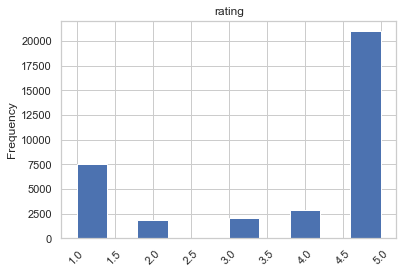

In [10]:
column_plot(full_df.rating, 'rating')

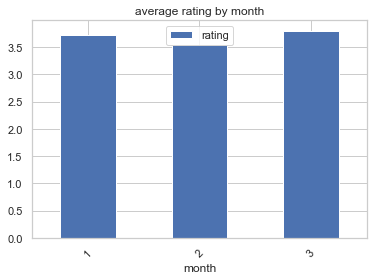

In [11]:
plot_groupby(full_df, ['month','rating'], kind='bar', title='average rating by month')

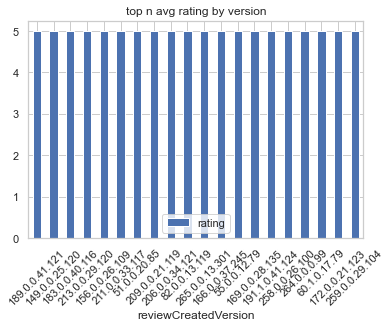

In [12]:
plot_groupby(full_df, ['reviewCreatedVersion', 'rating'], kind='bar', top_n=20,title='top n avg rating by version')

Because they're too many categories, view just top 20

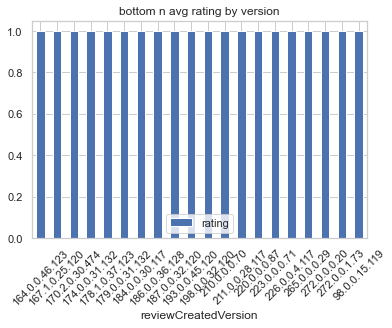

In [13]:
plot_groupby(full_df, ['reviewCreatedVersion', 'rating'], kind='bar', last_n=20,title='bottom n avg rating by version')

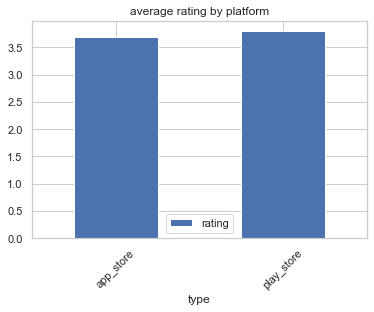

In [14]:
plot_groupby(full_df, ['type', 'rating'], kind='bar', title='average rating by platform')

# Sentiment Analyzer

In [15]:
sid = SentimentIntensityAnalyzer()

In [16]:
full_df['title_sentiments'] = full_df.clean_title.apply(lambda x: sid.polarity_scores(x)['compound'])
full_df['review_sentiments'] = full_df.clean_review.apply(lambda x: sid.polarity_scores(x)['compound'])

#generate a score from both review and title sentiments and normalize (to make the score between 0 - 1)
#type play_store has no title sentiment hence assign same score
full_df.loc[full_df.type =='play_store', 'title_sentiments'] = full_df.loc[full_df.type =='play_store','review_sentiments']
full_df['sentiment_score'] = full_df.title_sentiments + full_df.review_sentiments
full_df.sentiment_score = (full_df.sentiment_score - min(full_df.sentiment_score)) / (max(full_df.sentiment_score) - min(full_df.sentiment_score))


In [17]:
full_df.head()

index       userName                      review  rating  thumbsUpCount  \
0      0  Armygirl Rose                     amazing       5            0.0   
1      1   Shravanthi K        fav app and good app       5            1.0   
2      2  Muhammad Gana               good and fast       5            2.0   
3      3  parker wilson  si señor, el soy dé râncho       1           29.0   
4      4  kalpna Mishra                        nice       5            3.0   

  reviewCreatedVersion  replyContent  repliedAt        type title country  \
0       276.0.0.26.103           NaN        NaN  play_store  none      us   
1        275.0.0.27.98           NaN        NaN  play_store  none      us   
2                  NaN           NaN        NaN  play_store  none      us   
3        275.0.0.27.98           NaN        NaN  play_store  none      us   
4                  NaN           NaN        NaN  play_store  none      us   

   month               clean_review clean_title  title_sentiments  \
0      3                    amazing        none            0.5859   
1      3       fav app and good app        none            0.7096   
2      3              good and fast        none            0.4404   
3      3  si señor el soy dé râncho        none            0.0000   
4      3                       nice        none            0.4215   

   review_sentiments  sentiment_score  
0             0.5859         0.793517  
1             0.7096         0.855875  
2             0.4404         0.720169  
3             0.0000         0.498160  
4             0.4215         0.710642

In [18]:
def plot_sentiment(df, kind, title, col, top_n=None, last_n=None,indexby=False, **kwargs):
    
    if indexby:
        (df[df[col] == indexby].sentiment_score > 0.5).value_counts().plot(kind=kind, **kwargs)#, x=None, y=None)
    elif top_n:
        df.groupby(col)['sentiment_score'].mean().reset_index().sort_values(by='sentiment_score', ascending=False).head(top_n).plot(kind=kind, y='sentiment_score',x=col, **kwargs)
    elif last_n:
        df.groupby(col)['sentiment_score'].mean().reset_index().sort_values(by='sentiment_score', ascending=False).tail(last_n).plot(kind=kind, y='sentiment_score',x=col, **kwargs)
    else:
        df.groupby(col)['sentiment_score'].mean().plot(kind=kind, y='sentiment_score',x=col, **kwargs)
    plt.xticks(rotation = 45)
    plt.title(title)
    plt.show()

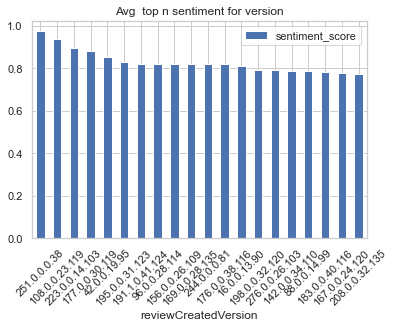

In [19]:
plot_sentiment(full_df, col='reviewCreatedVersion',kind='bar',top_n=20,title='Avg  top n sentiment for version')

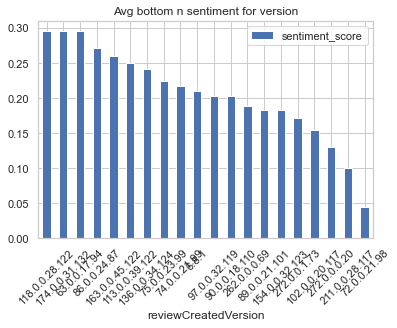

In [20]:
plot_sentiment(full_df, col='reviewCreatedVersion',kind='bar',last_n=20,title='Avg bottom n sentiment for version')

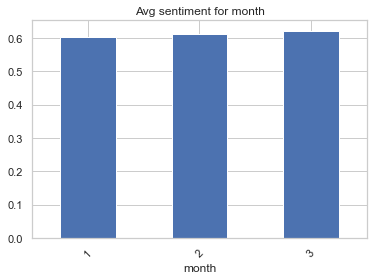

In [21]:
plot_sentiment(full_df, col='month',kind='bar',title='Avg sentiment for month')

True being positive sentiment and False means not positive

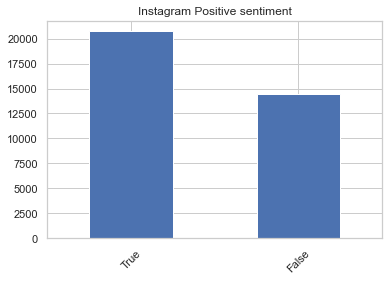

In [22]:
(full_df.sentiment_score > 0.5).value_counts().plot(kind='bar')
plt.xticks(rotation = 45)
plt.title('Instagram Positive sentiment');

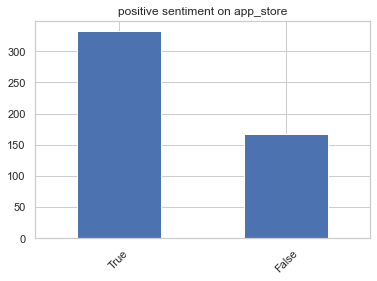

In [23]:
plot_sentiment(full_df, indexby='app_store', col='type', kind='bar', title='positive sentiment on app_store')

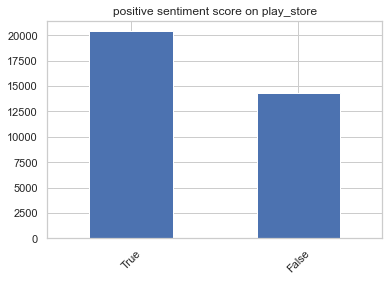

In [24]:
plot_sentiment(full_df, indexby='play_store', col='type', kind='bar', title='positive sentiment score on play_store')

# Create WordCloud

In [25]:
def create_word_cloud(df, col=None, indexby=None, custom=None, title='Word Cloud', include_title=False):
    
    '''
    df: dataframe
    col: column to index
    indexby: category interested in
    custom: custom query
    title: word cloud title
    include_title:  include title column
    '''
    
    if indexby:
        temp_df = df[df[col] == indexby]
    elif custom:
        temp_df = custom
    else:
        temp_df = df
    review_txt = ''
    title_txt = ''
    for i in range(temp_df.shape[0]):
        review_txt += ''.join(temp_df.clean_review[i]) + ' '
        title_txt += ''.join(temp_df.clean_title[i]) + ' '
   
    if include_title:
        wordcloud_title = WordCloud(width=800, height=800, colormap='coolwarm').generate(title_txt)
    wordcloud_review = WordCloud(width=800, height=800, colormap='coolwarm').generate(review_txt)
    
    if include_title:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 30))

        # plot the first image in the first subplot
        ax1.imshow(wordcloud_review)
        ax1.set_title(title + 'review', fontsize=23)
        ax1.tick_params(labelbottom=False, labelleft=False)

        # plot the second image in the second subplot
        ax2.imshow(wordcloud_title)
        ax2.set_title(title + 'title', fontsize=23)
        ax2.tick_params(labelbottom=False, labelleft=False)

        plt.yticks()
        plt.show();
        
    else:
        plt.figure(figsize = (8, 8))
        plt.imshow(wordcloud_review)
        plt.axis("off")
        plt.tight_layout(pad = 0)
        plt.title(title, fontsize=18)
        plt.show();

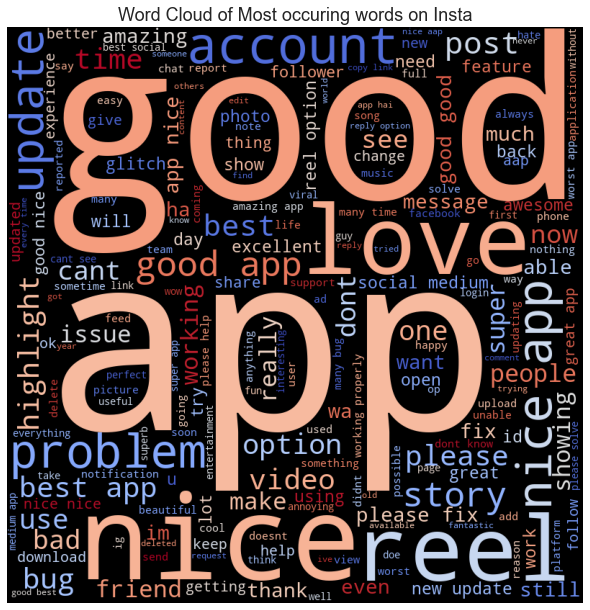

In [26]:
create_word_cloud(full_df, title='Word Cloud of Most occuring words on Insta')

In [27]:
full_df.groupby('reviewCreatedVersion')['clean_review'].apply(list).reset_index()

reviewCreatedVersion                                       clean_review
0                10.31.0  [i tried everything and it still not letting m...
1         100.0.0.17.129  [best, i cant ll this app, interesting very ea...
2         102.0.0.20.117  [it too bohring i cant scroll reel too boring ...
3         103.1.0.15.119  [nice, reel option is not showing when i am do...
4         107.0.0.27.121  [the update dont really improve anything for t...
..                   ...                                                ...
223        90.0.0.18.110  [igtv and reel ruined it for me i dont wanna s...
224        94.0.0.22.116  [reel not working, reel not working, reel not ...
225        96.0.0.28.114         [just love it, just love it, just love it]
226        97.0.0.32.119  [very bad experience with this new update ever...
227        98.0.0.15.119  [extremely predatory ad and stolen data the of...

[228 rows x 2 columns]

In [28]:
def group_df_wordcloud(df, col, indexby, nrow=2, ncol=2):
    
    group_df = df.groupby(col)[indexby].apply(list).reset_index()
    title_list = []
    for i in range(len(group_df)):
        title_list.append(' '.join(group_df.iloc[i][indexby]))

    #fig, axs = plt.subplots(nrow, ncol, figsize=(20,30))
    # axs = axs.flatten()
    fig = plt.figure(figsize=(20,20),)
    for j in range(len(title_list)):
        word_cloud = WordCloud(width=800, height=800, colormap='coolwarm').generate(title_list[j])

        plt.subplot(nrow, ncol, j+1)
        plt.imshow(word_cloud)
        plt.title('wordcloud for ' + col + ' ' + str(group_df.iloc[j][col]), fontsize=23)
        # axs[j].imshow(word_cloud)
        # axs[j].set_title('month' + str(group_df.iloc[j]['month']) + 'review' + 'word cloud', fontsize=23)
        # axs[j].tick_params(labelbottom=False, labelleft=False)
        plt.tick_params(labelbottom=False, labelleft=False)
        plt.axis('off')
    plt.subplots_adjust(bottom=0)
    plt.show();

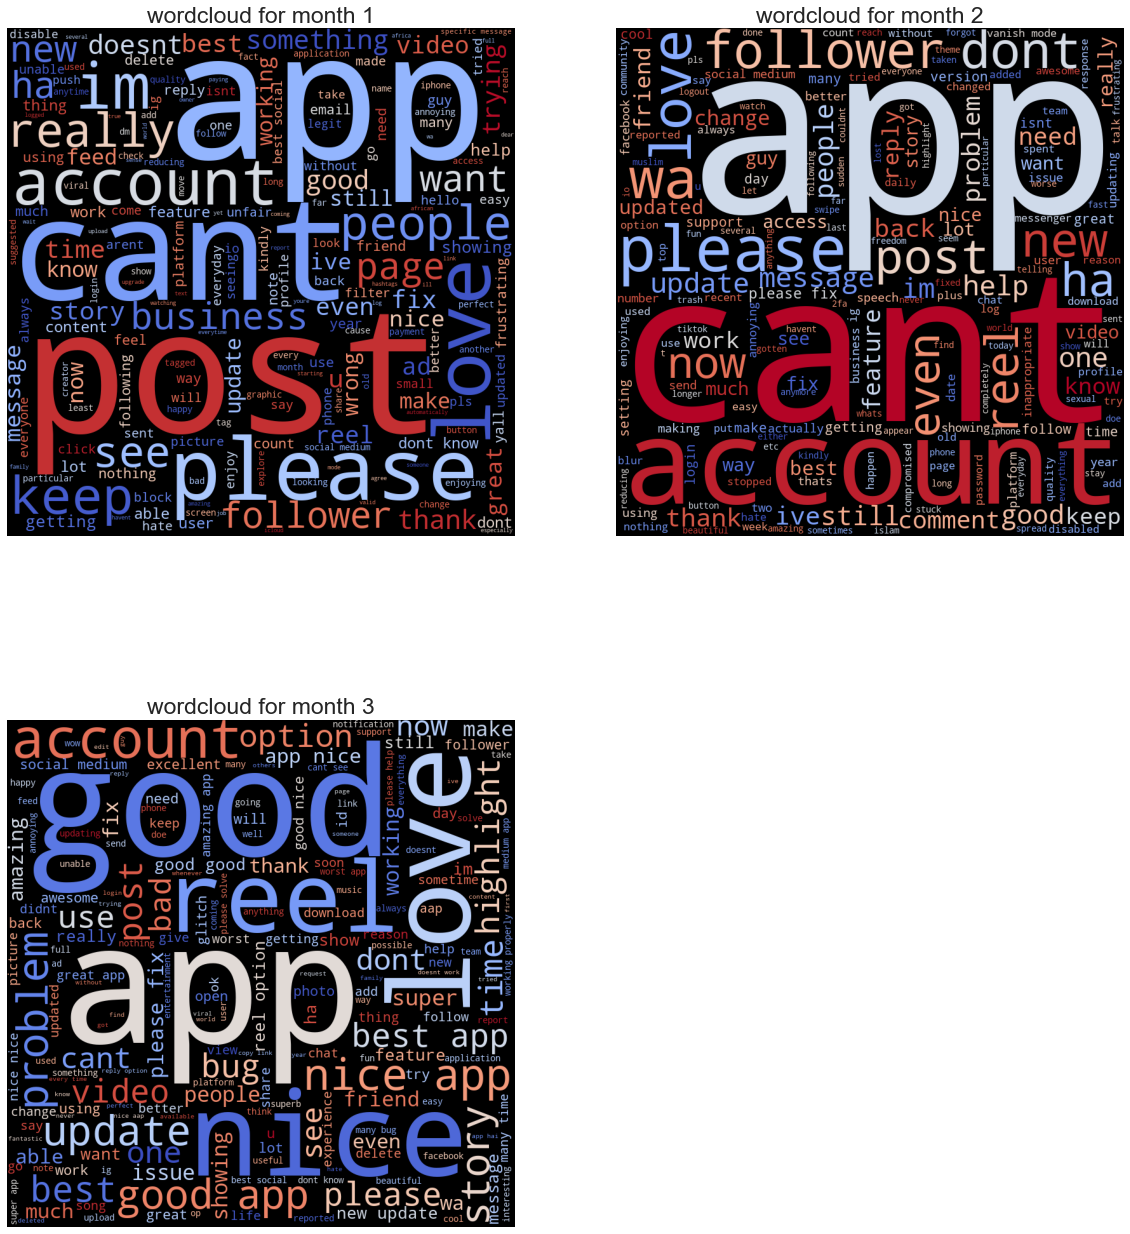

In [29]:
group_df_wordcloud(full_df, 'month', 'clean_review', 2,2)

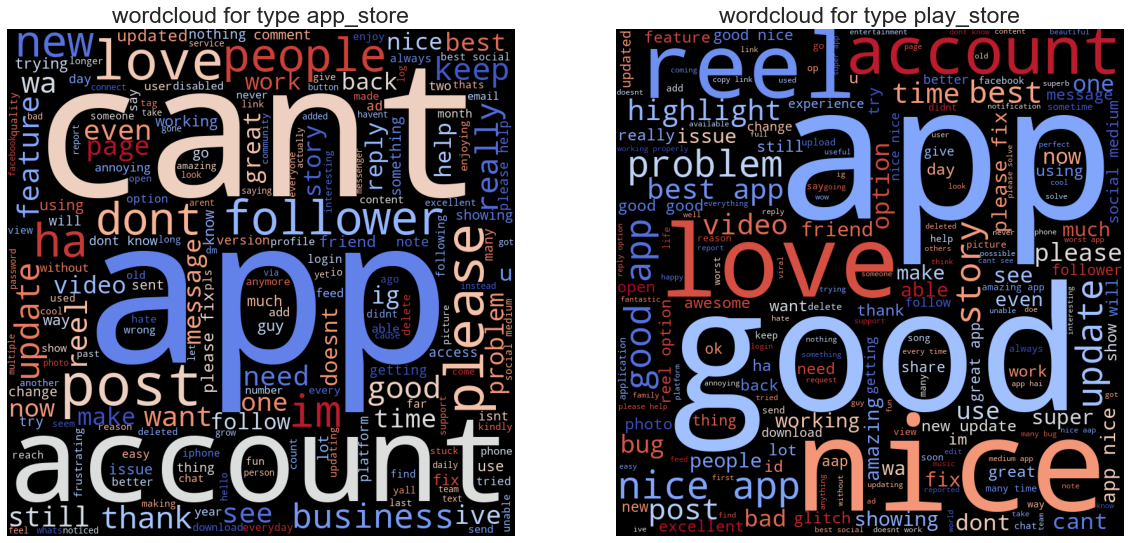

In [30]:
group_df_wordcloud(full_df, 'type', 'clean_review', 1,2)

create word cloud for the top 10 common versions

In [31]:
tmp = full_df[(full_df.reviewCreatedVersion.isin(full_df.reviewCreatedVersion.value_counts().head(10).index.tolist()))].rename(columns={'reviewCreatedVersion':'version'})

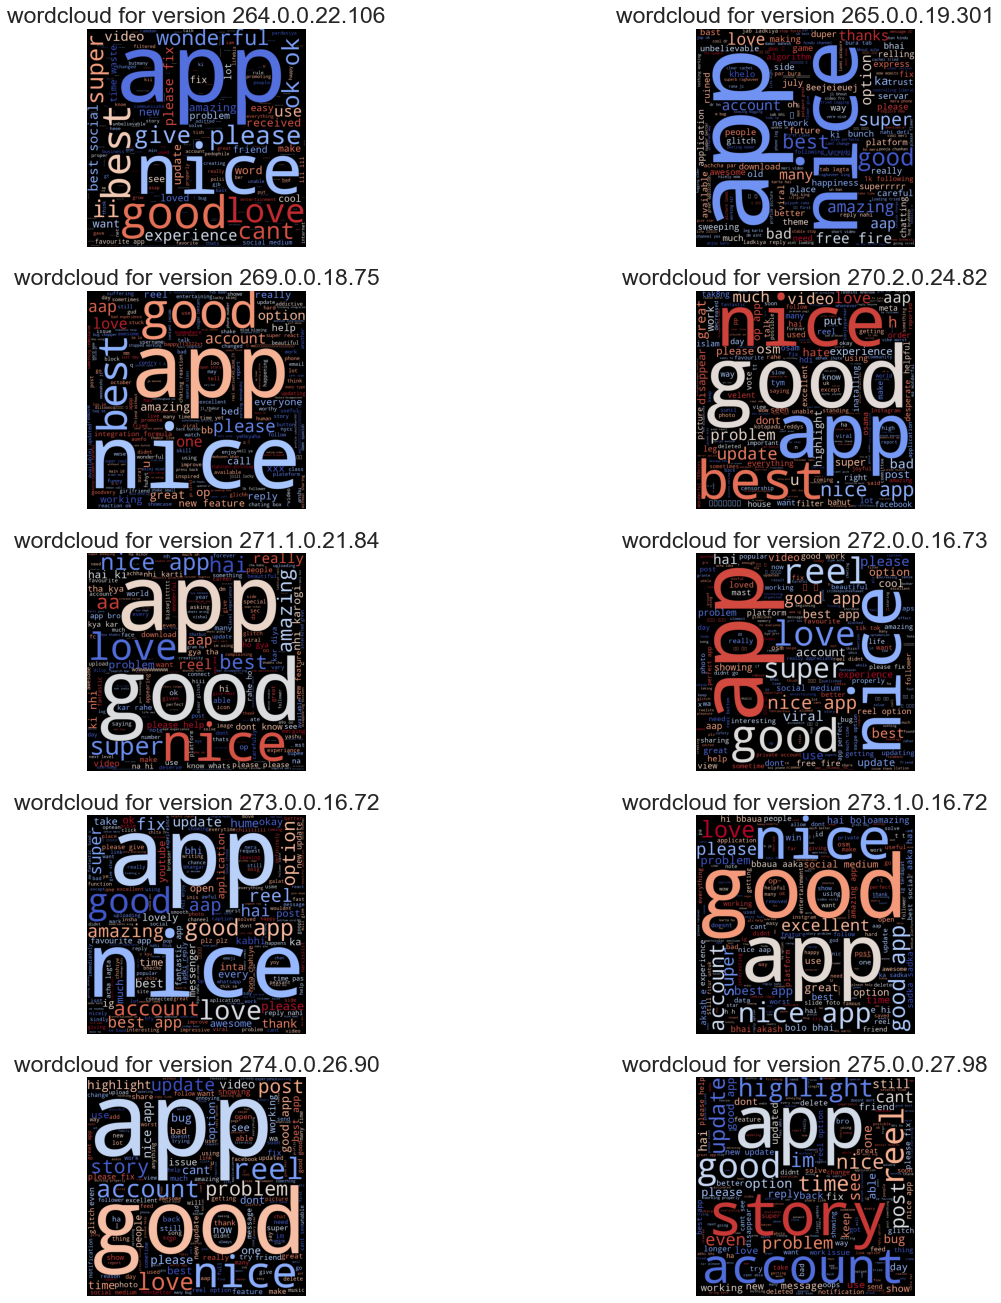

In [32]:
group_df_wordcloud(tmp, 'version', 'clean_review', 5,2)

In [33]:
full_df['positive_sentiment'] = full_df.sentiment_score.apply(lambda x: True if x > 0.5 else False)

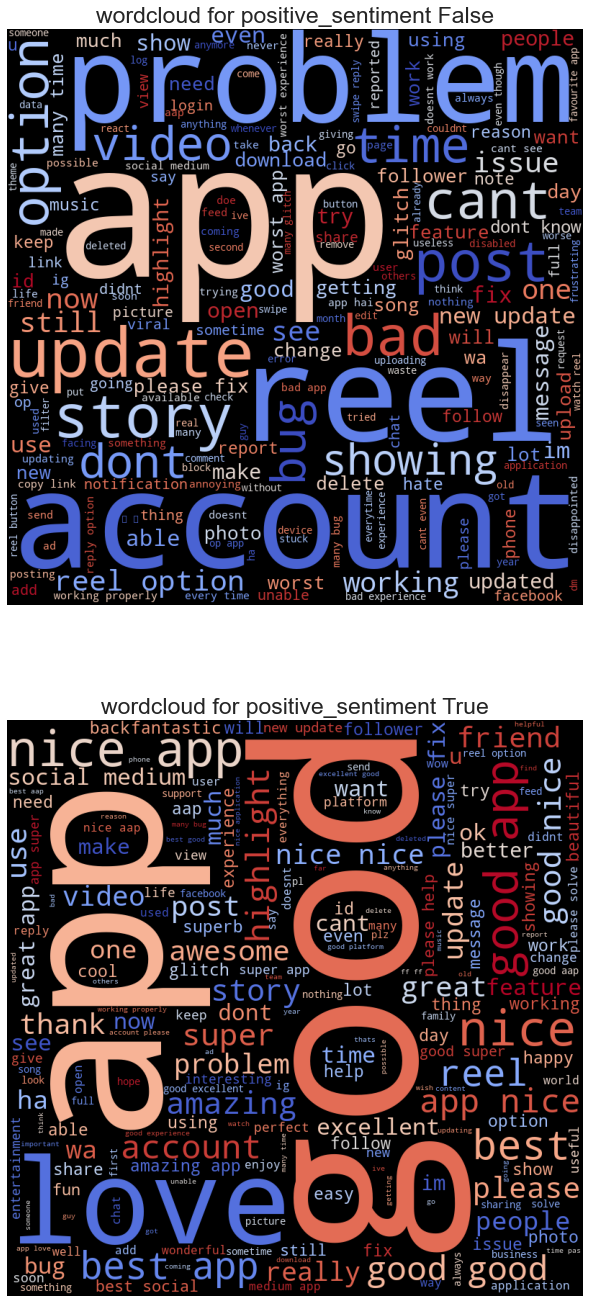

In [34]:
group_df_wordcloud(full_df, 'positive_sentiment', 'clean_review', 2,1)

In [35]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter

In [36]:
def top_n_words(df, title, indexby=[], n=10):
    
    tf = CountVectorizer (max_df=0.90, min_df=2, stop_words='english')
    if indexby:
        tf_feature = tf.fit_transform(df[df[indexby[0]] == indexby[1]].clean_review)
    else:
        tf_feature = tf.fit_transform(df.clean_review)
        
    tfdf = pd.DataFrame(tf_feature.toarray(), columns=tf.get_feature_names_out())
    tfdf.sum(axis=0).sort_values(ascending=False).head(n).plot(kind='bar')
    plt.title(title)
    plt.xticks(rotation='45');

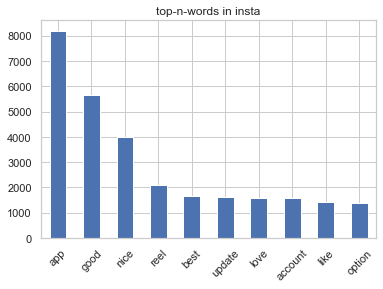

In [37]:
top_n_words(full_df,'top-n-words in insta')

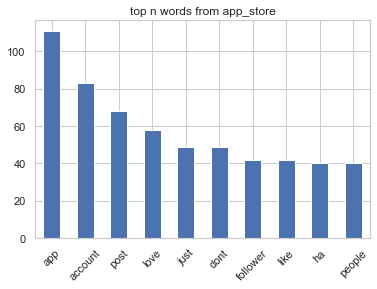

In [38]:
top_n_words(full_df, 'top n words from app_store',['type','app_store'])

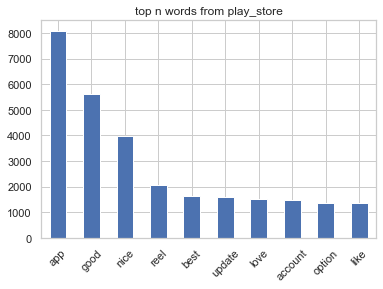

In [39]:
top_n_words(full_df, 'top n words from play_store',['type','play_store'])

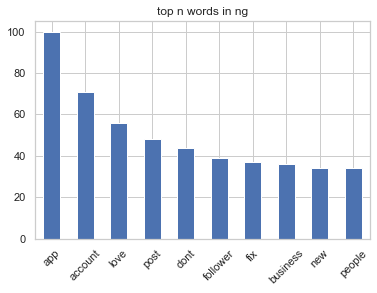

In [40]:
top_n_words(full_df, 'top n words in ng',['country','ng'])

top n most common words used in positive review

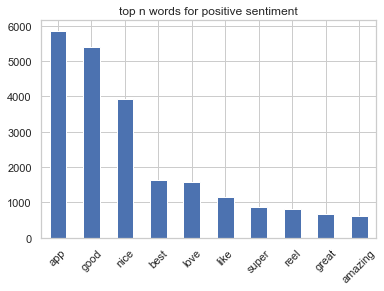

In [41]:
top_n_words(full_df, 'top n words for positive sentiment', ['positive_sentiment', True])

top n most common words used in negative review

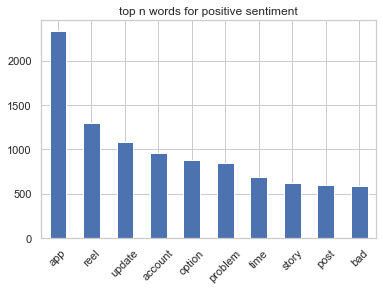

In [42]:
top_n_words(full_df, 'top n words for positive sentiment', ['positive_sentiment', False])

# TOPIC MODELLING

classify each of the reviews to cons, issues, feedback, pros

This is expected to be improved upon

In [43]:
def preprocess_gensim(text):
    return [token for token in simple_preprocess(text) if token not in gensim.parsing.preprocessing.STOPWORDS]

tp_df = full_df.copy()
tp_df['gensim_review'] = tp_df['clean_review'].apply(preprocess_gensim)

# Create a dictionary and corpus of the preprocessed text data
dictionary = Dictionary(tp_df['gensim_review'])
corpus = [dictionary.doc2bow(text) for text in tp_df['gensim_review']]

# Train an LDA model on the corpus
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=20, random_state=24)

# Get the topic distribution for each review in the dataframe
topic_dist = []
for i in range(len(tp_df)):
    text_bow = dictionary.doc2bow(tp_df.loc[i, 'gensim_review'])
    topic_probs = lda_model.get_document_topics(text_bow)
    topic_dist.append(dict(topic_probs))

In [44]:
full_df['topic_distribution'] = topic_dist

# Classify each review into a topic based on the highest probability topic in its distribution
topic_names = {0: 'cons', 1: 'issues',  2: 'feedback', 3:'pros', 4:'pros'}

In [45]:
full_df['topic'] = full_df['topic_distribution'].apply(lambda x: topic_names[max(x.items(), key=lambda item: item[1])[0]])

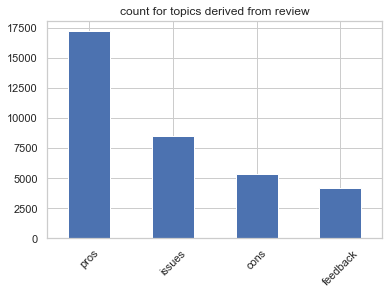

In [46]:
full_df.topic.value_counts().plot(kind='bar')
plt.title('count for topics derived from review')
plt.xticks(rotation=45);

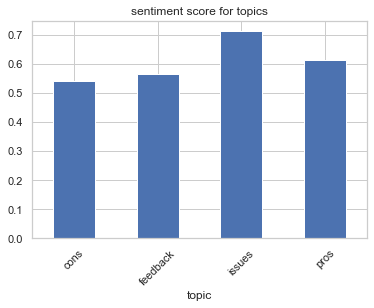

In [47]:
plot_sentiment(full_df, kind='bar',title = 'sentiment score for topics', col='topic')

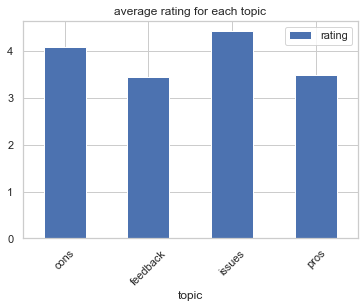

In [48]:
plot_groupby(full_df, ['topic', 'rating'], 'bar', title='average rating for each topic')

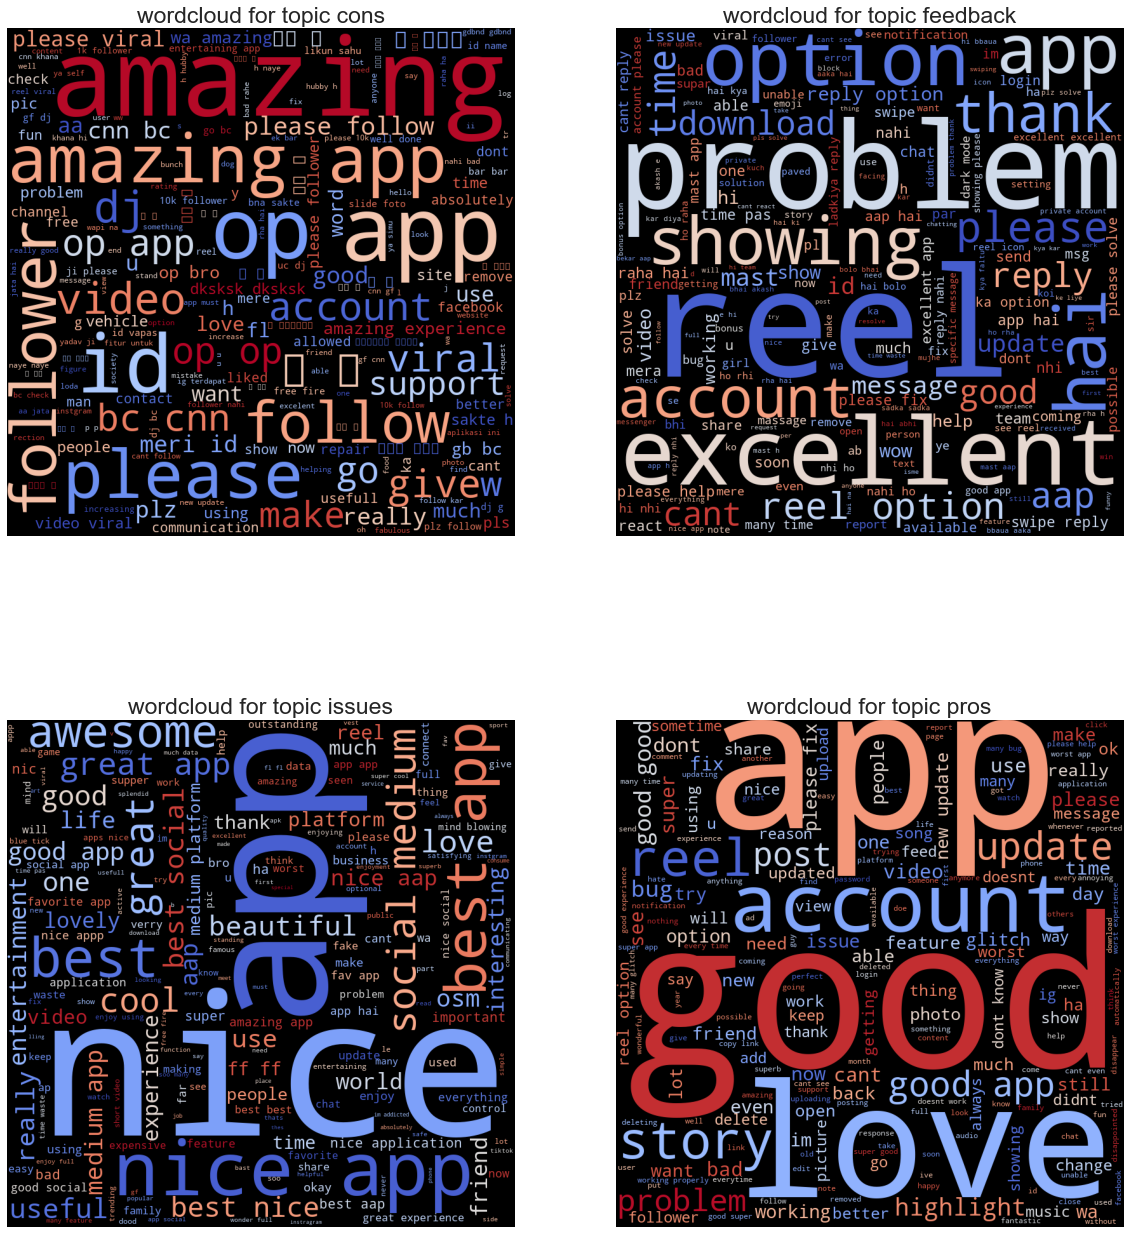

In [49]:
group_df_wordcloud(full_df, 'topic', 'clean_review',)

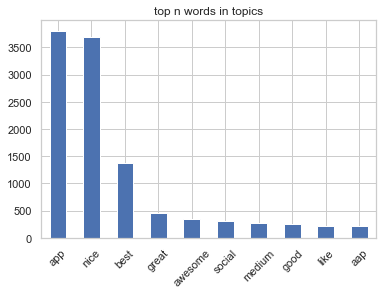

In [50]:
top_n_words(full_df, 'top n words in topics', ['topic', 'issues'])

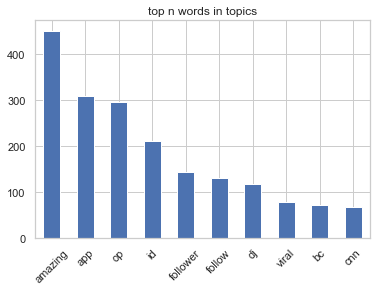

In [51]:
top_n_words(full_df, 'top n words in topics', ['topic', 'cons'])

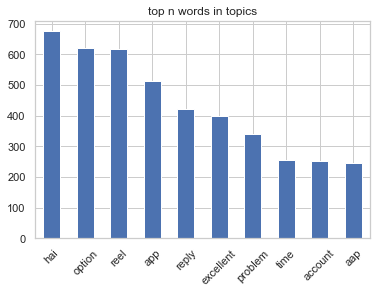

In [52]:
top_n_words(full_df, 'top n words in topics', ['topic', 'feedback'])